In [1]:
import numpy as np
from scipy import integrate
import scipy.io as sio

In [2]:
dat = sio.loadmat('data_set')

In [5]:
data = dat['data']
x0 = dat['x0']
true_states = dat['true_states']

In [6]:
x0

array([[5140.60468395,   39.62501859]])

In [7]:
#Select case type ('case 1' through 'case 4')
casetype = 'case 4'

In [8]:
#Set ensemble size
N = 100

#Set SIR model parameters
Np = 9e4
lamb = 100
m = 0.02
b0 = 1800
b1 = 0.08

In [9]:
#Time points for observations
deltaT = 1/12

In [10]:
tstart = 0.0
tend = 10.0
tdata = np.linspace(tstart,
                    tend,
                    num=int((tend-tstart+deltaT)/deltaT),
                    endpoint=True
                   )

In [9]:
#Generate prior ensembles
true_init = x0

aS = 0.9*true_init[0][0]
bS = 1.1*true_init[0][0]

uniS = aS+(bS-aS)*np.random.rand(1,N)

aI = 0.9*true_init[0][1]
bI = 1.1*true_init[0][1] 

uniI = aI+(bI-aI)*np.random.rand(1,N)

In [10]:
#Store ensembles
S = np.zeros((3,N))

S[0,:] = uniS
S[1,:] = uniI 

In [11]:
#Ensemble statistics
xbar1 = (1/N)*S.sum(axis=1)

gamma1 = ((S-xbar1[:,None]).dot((S-xbar1[:,None]).T))/(N-1)

In [12]:
#Store ensemble mean, +/- 2 standard deviation curves
fmean = np.zeros((len(data),3))
fplus = np.zeros((len(data),3))
fminus = np.zeros((len(data),3))

fmean[0,:] = xbar1
fplus[0,:] = (abs(2*np.sqrt(np.diag(gamma1)))).T+fmean[0,:]
fminus[0,:] = (-abs(2*np.sqrt(np.diag(gamma1)))).T+fmean[0,:]

In [13]:
stdC = 0.2
stdD = 1
D = stdD**2
nu = np.zeros((1,N))

In [14]:
#Functions to compute observation model predictions
def IofT(S,rho):
    G = rho*np.array([0,1])
    I = G[:,None]*S
    return I

def Integral(nu,rho):
    I = rho*nu
    return I

In [15]:
#Main time loop
for j in range(1,len(data)):
    #Prediction step
    for n in range(N):
        SIR_rhs = lambda t,Xt: [m*(Np-Xt[0])-((b0*(1+b1*np.cos(2*np.pi*t))*Xt[0]*Xt[1])/Np),
            ((b0*(1+b1*np.cos(2*np.pi*t))*Xt[0]*Xt[1])/Np)-(lamb + m)*Xt[1],
            (b0*(1+b1*np.cos(2*np.pi*t))*Xt[0]*Xt[1])/Np]
        
        ts = [tdata[j-1],tdata[j]]
        
        x0 = [S[0,n],S[1,n],0]
        
        sol = integrate.solve_ivp(SIR_rhs,ts,x0)
        Y = sol.y
        
        S[:,n] = (Y[:,-1]).T+stdC*np.random.randn(1,3)
        nu[:,n] = Y[2,-1]
    #Ensemble mean
    xbar = (1/N)*S.sum(axis=1)

    #Analysis Step
    #Compute model prediction based on observation function selection
    if casetype=='case 1':
        yhat = IofT(S[0:1,:],1)
    elif casetype=='case 2':
        yhat = IofT(S[0:1,:],0.7)
    elif casetype=='case 3':
        yhat = Integral(nu,1);
    elif casetype=='case 4':
        yhat = Integral(nu,0.7);
    else:
        print('Case not found, try again')
    
    #Kalman Gain
    yhatbar = (1/N)*yhat.sum(axis=1)
    cross = ((S-xbar[:,None]).dot((yhat-yhatbar).T))/(N-1)
    forecast = ((yhat-yhatbar).dot((yhat-yhatbar).T))/(N-1)
    K = cross/(forecast + D)
    ydata = data[j]+stdD*np.random.randn(1,N)
    
    #Update ensemble
    S = S + K*(ydata-yhat)
    
    #Ensemble statistics
    fmean[j,:] = xbar
    gamma = ((S-(xbar[:,None])).dot((S-(xbar[:,None])).T))/(N-1)
    fplus[j,:] = (abs(2*np.sqrt(np.diag(gamma)))).T+fmean[j,:]
    fminus[j,:] = (-abs(2*np.sqrt(np.diag(gamma)))).T+fmean[j,:]

In [16]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Population [individuals]')

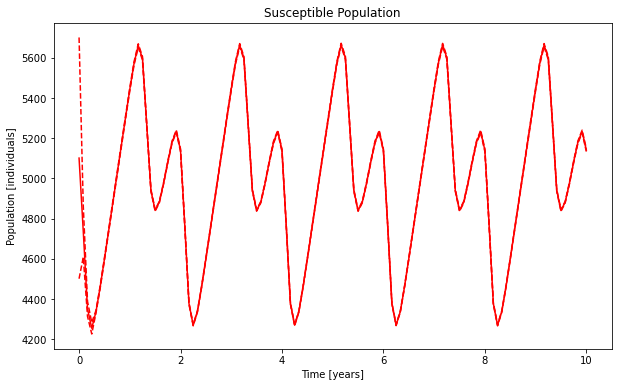

In [17]:
plt.figure(figsize=(10,6))
plt.plot(tdata,fmean[:,0],'r-')
plt.plot(tdata,fplus[:,0],'r--')
plt.plot(tdata,fminus[:,0],'r--')
plt.title('Susceptible Population')
plt.xlabel('Time [years]')
plt.ylabel('Population [individuals]')

Text(0, 0.5, 'Population [individuals]')

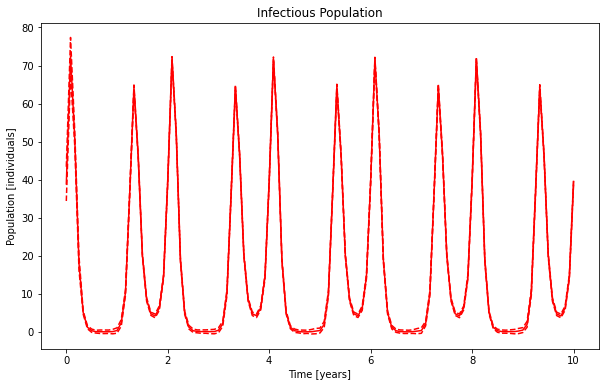

In [18]:
plt.figure(figsize=(10,6))
plt.plot(tdata,fmean[:,1],'r-')
plt.plot(tdata,fplus[:,1],'r--')
plt.plot(tdata,fminus[:,1],'r--')
if (casetype=='case 1') | (casetype=='case 2'):
    p=plt.plot(tdata,data,'k.')
plt.title('Infectious Population')
plt.xlabel('Time [years]')
plt.ylabel('Population [individuals]')

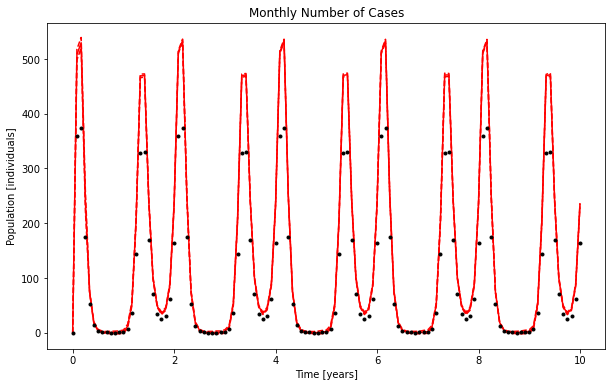

In [19]:
plt.figure(figsize=(10,6))
if (casetype=='case 3') | (casetype=='case 4'):
    plt.plot(tdata,fmean[:,2],'r-')
    plt.plot(tdata,fplus[:,2],'r--')
    plt.plot(tdata,fminus[:,2],'r--')
    p=plt.plot(tdata,data,'k.')
    plt.title('Monthly Number of Cases')
    plt.xlabel('Time [years]')
    plt.ylabel('Population [individuals]')